In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../data/raw/nytaxi2022.csv', usecols=[
     "tpep_pickup_datetime", "tpep_dropoff_datetime", "passenger_count", "trip_distance", 
     "RatecodeID", "PULocationID", "DOLocationID", "payment_type", 
     "extra", "total_amount"])
print(df.shape)
# df.head()

(39656098, 10)


## condition 1

In [ ]:
# improvements

# locationid = (
#     df['PULocationID'].between(1, 265) &
#     df['DOLocationID'].between(1, 265))
# df = df[locationid] 写法 
# 比
# df = df[df['PULocationID'].between(1, 265)] 会创建一个新的 DataFrame 副本，把原 df 中符合条件的行复制出来，然后再赋值给 df。
# df = df[df['DOLocationID'].between(1, 265)] 又复制一次。在这个过程中，旧的df副本可能还没有被垃圾回收释放掉，于是内存里就同时存在两个大副本+原始 df，对几千万行的数据来说，很容易Kernel Crash
# 写法要好，但还是有复制

# 用drop或者query不会复制，但是query好像写不了判断整数 

In [3]:
# df = df.drop_duplicates()
df = df.dropna()

condition1 = (
    (df['passenger_count'] > 0) & (df['passenger_count'] <= 6) &
    (df['trip_distance'] > 0) & 
    (df['RatecodeID'] < 6) & (df['RatecodeID'] % 1 == 0) &        # (df['RatecodeID'] == 6).sum() output 111
    df['PULocationID'].between(1, 265) & (df['PULocationID'] % 1 == 0) &
    df['DOLocationID'].between(1, 265) & (df['DOLocationID'] % 1 == 0) &
    (df['extra'] >= 0) & (df['extra'] < 20) &
    (df["total_amount"] > 0) & (df["total_amount"] < 1000)
)

df.drop(df[~condition1].index, inplace=True)

df.shape

(36708331, 10)

## condition 2 (time)

In [4]:
# %H → 24h %I → 12h
df['tpep_pickup_datetime'] = pd.to_datetime(df["tpep_pickup_datetime"], format = "%m/%d/%Y %I:%M:%S %p", errors='coerce')
df['tpep_dropoff_datetime'] = pd.to_datetime(df["tpep_dropoff_datetime"], format = "%m/%d/%Y %I:%M:%S %p", errors='coerce')
df = df.dropna(subset=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])

year_counts = df['tpep_pickup_datetime'].dt.year.value_counts().sort_index()
print(year_counts)

tpep_pickup_datetime
2001           6
2002         355
2003           7
2008          33
2009          36
2021          23
2022    36707865
2023           6
Name: count, dtype: int64


In [5]:
df['trip_dur_min'] = (
    (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60.0
).astype('float32')

pickup_year = df['tpep_pickup_datetime'].dt.year
dropoff_year = df['tpep_dropoff_datetime'].dt.year

condition2 = (
    (pickup_year == 2022) & (dropoff_year == 2022) &
    (df['trip_dur_min'] > 0) & (df['trip_dur_min'] < 120)
)
df.drop(df[~condition2].index, inplace=True)

df.shape

(36651998, 11)

In [ ]:
# Unix
# arr_pick = df['tpep_pickup_datetime'].to_numpy(dtype='datetime64[ns]').view('i8')
# arr_drop = df['tpep_dropoff_datetime'].to_numpy(dtype='datetime64[ns]').view('i8')
# df['pickup_ts'] = (arr_pick // 10**9).astype('int64')
# df['dropoff_ts'] = (arr_drop // 10**9).astype('int64')
# df = df.drop(columns=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])
# df.shape

In [ ]:
# subtract periodic characteristics（hour-of-day / day-of-week）
hours = df['tpep_pickup_datetime'].dt.hour
days  = df['tpep_pickup_datetime'].dt.dayofweek
df['hour_sin'] = np.sin(2 * np.pi * hours / 24)
df['hour_cos'] = np.cos(2 * np.pi * hours / 24)
df['day_sin']  = np.sin(2 * np.pi * days / 7)
df['day_cos']  = np.cos(2 * np.pi * days / 7)

df.shape

(36651998, 15)

### draw plots

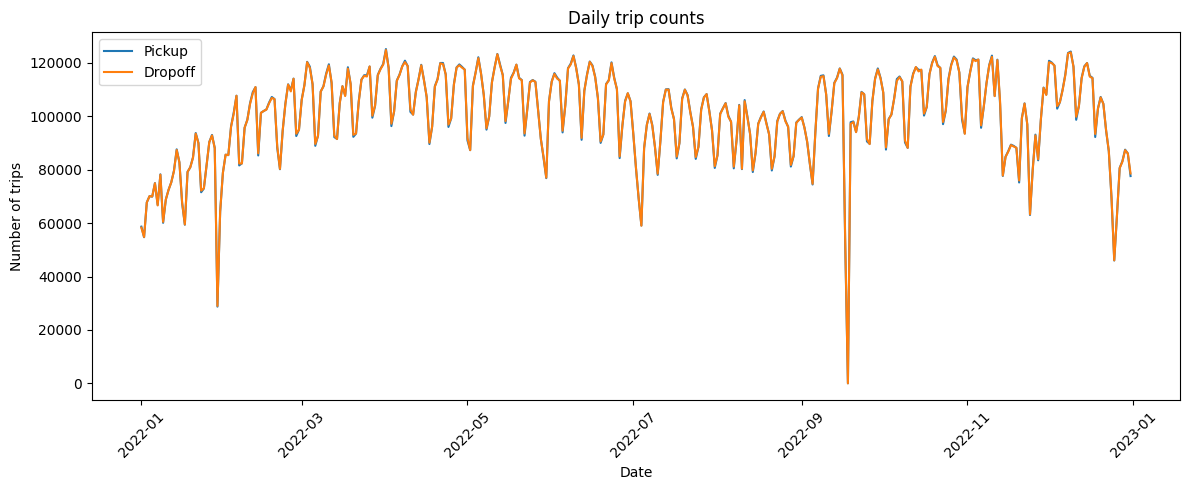

In [7]:
df['pickup_date'] = df['tpep_pickup_datetime'].dt.date
df['dropoff_date'] = df['tpep_dropoff_datetime'].dt.date

pickup_counts = df['pickup_date'].value_counts().sort_index()
dropoff_counts = df['dropoff_date'].value_counts().sort_index()

plt.figure(figsize=(12,5))
plt.plot(pickup_counts.index, pickup_counts.values, label='Pickup')
plt.plot(dropoff_counts.index, dropoff_counts.values, label='Dropoff')
plt.xlabel('Date')
plt.ylabel('Number of trips')
plt.title('Daily trip counts')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

df = df.drop(columns=['pickup_date', 'dropoff_date'])

/tmp/ipykernel_308941/945459645.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


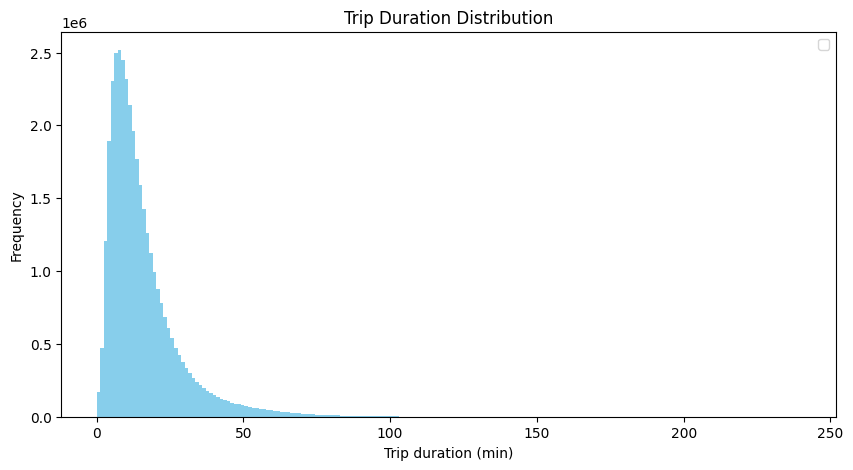

In [8]:
plt.figure(figsize=(10,5))
plt.hist(df['trip_dur_min'], bins=200, range=(0, 240), color='skyblue')
plt.xlabel("Trip duration (min)")
plt.ylabel("Frequency")
plt.title("Trip Duration Distribution")
plt.legend()
plt.show()

### delete former data columns

In [9]:
df.drop(columns=['tpep_pickup_datetime', 'tpep_dropoff_datetime'], inplace=True, errors='ignore')
df.shape

(36651998, 13)

In [11]:
# df.head

## condition 3

In [3]:
# cols_to_check = ["passenger_count", 'trip_dur_min', 'pickup_ts', 'dropoff_ts', "trip_distance", "RatecodeID", "payment_type", "extra", "total_amount"]

# df[cols_to_check].plot(kind='box', subplots=True, layout=(3,3), figsize=(12,8))
# plt.tight_layout()
# plt.show()

In [12]:
cols_to_check = ['trip_dur_min', "trip_distance", "total_amount", "extra"]

for col in cols_to_check:
    Q1 = df[col].quantile(0.2)
    Q3 = df[col].quantile(0.8)
    IQR = Q3 - Q1
    upper = Q3 + 20 * IQR   

    outlier_idx = df.index[df[col] > upper]   
    print(f"{col}: upper={upper:.2f}, will through away {len(outlier_idx)} extreme large values")
    df.drop(index=outlier_idx, inplace=True)


trip_dur_min: upper=332.12, will through away 0 extreme large values
trip_distance: upper=70.30, will through away 840 extreme large values
total_amount: upper=304.16, will through away 1209 extreme large values
extra: upper=52.50, will through away 0 extreme large values


In [13]:
cols_to_check = ['trip_dur_min', "trip_distance", "total_amount", "extra"]

for col in cols_to_check:
    upper = df[col].quantile(0.999)  
    outlier_idx = df.index[df[col] > upper]

    print(f"{col}: upper={upper:.2f}, will through away {len(outlier_idx)} extreme large values")
    df.drop(index=outlier_idx, inplace=True)

df.shape

trip_dur_min: upper=90.93, will through away 36641 extreme large values
trip_distance: upper=28.44, will through away 36589 extreme large values
total_amount: upper=114.52, will through away 36576 extreme large values
extra: upper=8.25, will through away 5629 extreme large values


(36534514, 13)

In [14]:
# cols_to_check = ['trip_dur_min', "trip_distance", "total_amount"]

# df[cols_to_check].plot(kind='box', subplots=True, layout=(1,3), figsize=(6,2))
# plt.tight_layout()
# plt.show()

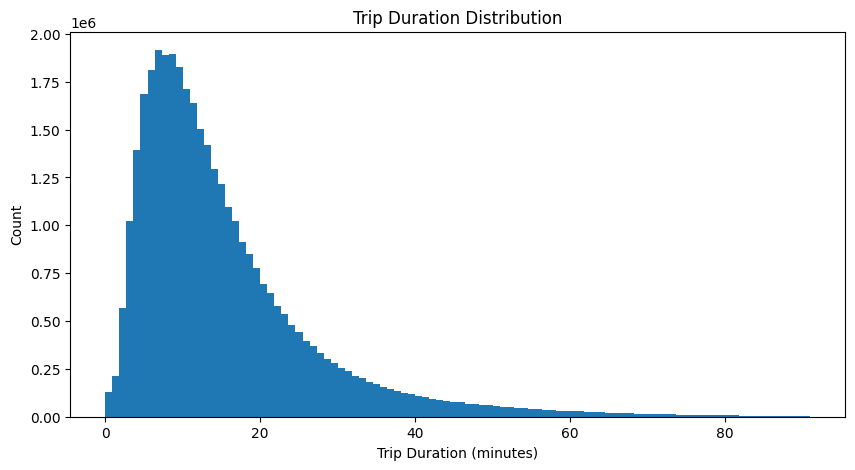

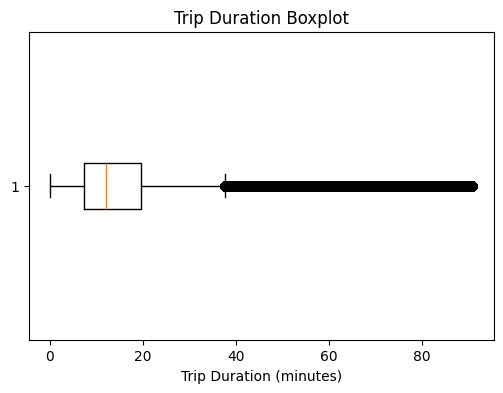

In [15]:
# Histogram
plt.figure(figsize=(10,5))
plt.hist(df['trip_dur_min'], bins=100)
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Count')
plt.title('Trip Duration Distribution')
plt.show()

# Box plot
plt.figure(figsize=(6,4))
plt.boxplot(df['trip_dur_min'], vert=False)
plt.xlabel('Trip Duration (minutes)')
plt.title('Trip Duration Boxplot')
plt.show()

## one-hot & normalize

In [16]:
from pandas.api.types import CategoricalDtype

df['RatecodeID'] = df['RatecodeID'].astype(CategoricalDtype(categories=[1,2,3,4,5], ordered=False))
df['payment_type'] = df['payment_type'].astype(CategoricalDtype(categories=[1,2,3,4], ordered=False))

df = pd.get_dummies(df,
                    columns=['RatecodeID', 'payment_type'], 
                    prefix=['Ratecode', 'paytype'],
                    dummy_na=False)
df.shape

(36534514, 20)

In [17]:
num_cols = ['passenger_count','trip_distance','extra','hour_sin','hour_cos', 'day_sin', 'day_cos', 'trip_dur_min','PULocationID','DOLocationID']
for col in num_cols:
    col_min = df[col].min()
    col_max = df[col].max()
    if col_max > col_min:
        df[col] = (df[col] - col_min) / (col_max - col_min)

## move total_amount to the last column

In [18]:
cols = [c for c in df.columns if c != "total_amount"] + ["total_amount"]
df = df[cols]

In [19]:
df.head()

,passenger_count,trip_distance,PULocationID,DOLocationID,extra,trip_dur_min,hour_sin,hour_cos,day_sin,day_cos,Ratecode_1,Ratecode_2,Ratecode_3,Ratecode_4,Ratecode_5,paytype_1,paytype_2,paytype_3,paytype_4,total_amount
0,0.2,0.133310,0.534091,0.890152,0.363636,0.195784,0.5,1.0,0.0,0.356896,True,False,False,False,False,True,False,False,False,21.95
1,0.0,0.073514,0.890152,0.155303,0.060606,0.092209,0.5,1.0,0.0,0.356896,True,False,False,False,False,True,False,False,False,13.30
2,0.0,0.033767,0.625000,0.625000,0.060606,0.098442,0.5,1.0,0.0,0.356896,True,False,False,False,False,True,False,False,False,10.56
3,0.0,0.037988,0.428030,0.253788,0.060606,0.110174,0.5,1.0,0.0,0.356896,True,False,False,False,False,False,True,False,False,11.80
4,0.0,0.150897,0.253788,0.613636,0.060606,0.412649,0.5,1.0,0.0,0.356896,True,False,False,False,False,True,False,False,False,30.30


## save as .parquet

In [20]:
import os

os.makedirs("../data/processed", exist_ok=True)

# 保存为 parquet
df.to_parquet("../data/processed/dataall999.parquet", index=False)
print("Saved to ../data/processed/dataall999.parquet")



Saved to ../data/processed/dataall999.parquet


## check

In [21]:
import pyarrow.parquet as pq

# 读 parquet 文件的元信息
parquet_file = pq.ParquetFile("../data/processed/dataall999.parquet")

print("Number of row groups:", parquet_file.num_row_groups)

# 查看每个 row group 的大小和行数
for i in range(parquet_file.num_row_groups):
    rg_meta = parquet_file.metadata.row_group(i)
    print(f"Row Group {i}: {rg_meta.num_rows} rows, {rg_meta.total_byte_size/1024/1024:.2f} MB")


Number of row groups: 35
Row Group 0: 1048576 rows, 9.28 MB
Row Group 1: 1048576 rows, 9.25 MB
Row Group 2: 1048576 rows, 9.24 MB
Row Group 3: 1048576 rows, 9.12 MB
Row Group 4: 1048576 rows, 9.34 MB
Row Group 5: 1048576 rows, 9.23 MB
Row Group 6: 1048576 rows, 9.25 MB
Row Group 7: 1048576 rows, 9.23 MB
Row Group 8: 1048576 rows, 9.13 MB
Row Group 9: 1048576 rows, 9.12 MB
Row Group 10: 1048576 rows, 9.35 MB
Row Group 11: 1048576 rows, 9.24 MB
Row Group 12: 1048576 rows, 9.24 MB
Row Group 13: 1048576 rows, 9.24 MB
Row Group 14: 1048576 rows, 9.22 MB
Row Group 15: 1048576 rows, 9.24 MB
Row Group 16: 1048576 rows, 9.24 MB
Row Group 17: 1048576 rows, 9.25 MB
Row Group 18: 1048576 rows, 9.11 MB
Row Group 19: 1048576 rows, 9.19 MB
Row Group 20: 1048576 rows, 9.32 MB
Row Group 21: 1048576 rows, 9.08 MB
Row Group 22: 1048576 rows, 9.32 MB
Row Group 23: 1048576 rows, 9.32 MB
Row Group 24: 1048576 rows, 9.21 MB
Row Group 25: 1048576 rows, 9.31 MB
Row Group 26: 1048576 rows, 9.18 MB
Row Group 27:

In [23]:
parquet_file.read_row_group(34).to_pandas().head()

,passenger_count,trip_distance,PULocationID,DOLocationID,extra,trip_dur_min,hour_sin,hour_cos,day_sin,day_cos,Ratecode_1,Ratecode_2,Ratecode_3,Ratecode_4,Ratecode_5,paytype_1,paytype_2,paytype_3,paytype_4,total_amount
0,0.2,0.055575,0.893939,0.992424,0.121212,0.061045,0.146447,0.853553,0.900969,0.801938,True,False,False,False,False,True,False,False,False,16.32
1,0.2,0.022863,0.992424,0.890152,0.121212,0.053346,0.146447,0.853553,0.900969,0.801938,True,False,False,False,False,True,False,False,False,13.00
2,0.0,0.066479,0.424242,0.867424,0.424242,0.270577,0.146447,0.853553,0.900969,0.801938,True,False,False,False,False,True,False,False,False,31.90
3,0.0,0.119240,0.867424,0.011364,0.424242,0.272411,0.146447,0.853553,0.900969,0.801938,True,False,False,False,False,False,True,False,False,25.50
4,0.0,0.075624,0.882576,0.863636,0.121212,0.120990,0.146447,0.853553,0.900969,0.801938,True,False,False,False,False,True,False,False,False,21.36


In [18]:
df = pd.read_parquet("../data/processed/dataall999.parquet")  
print(df["total_amount"].min())  
print(df["total_amount"].max())  
print(df["total_amount"].mean())  
print(df["total_amount"].std())  

0.04
114.53
21.122003427838482
15.530630682886251
